# Synthetic Timeseries with EBTEL
Create a synthetic intensity timeseries with EBTEL in few different ways

1. Convolution of many loops, each with 1 event
2. One loop with many events

Vary number of events, number loops, interval between events

In [198]:
import subprocess
import os

import numpy as np
from scipy.interpolate import splev
import astropy.units as u
import matplotlib.pyplot as plt
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.util import xml_io

%matplotlib inline

Create 10 different timeseries, each with the event placed at a slightly offset time. We'll just choose an arbitrary AIA channel to use for now. 

In [222]:
base = xml_io.InputHandler('/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml').lookup_vars()
base['total_time'] = 1e4
base['loop_length'] = 4e9
base['output_filename'] = 'test'
base['use_adaptive_solver'] = False
base['tau'] = 1
base['use_flux_limiting'] = True

In [223]:
aia = InstrumentSDOAIA([0,1]*u.s)
temperature_grid = np.logspace(4,8,100)

In [224]:
num_loops = 30
interval = base['total_time']/num_loops
duration = 200.0
timeseries = []
for i in range(num_loops):
    config = base.copy()
    rise_start = i*interval
    config['heating']['events'] = [{'event':{'decay_start': rise_start+duration/2.,
                                             'decay_end':rise_start+duration,
                                             'rise_start': rise_start,
                                             'rise_end': rise_start+duration/2.,
                                             'magnitude':np.random.uniform(low=1e-3,high=1e-3)}}]
    oh = xml_io.OutputHandler(base['output_filename']+'.xml',config)
    oh.print_to_xml()
    subprocess.call(['/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/bin/ebtel++.run', '-c',
                     base['output_filename']+'.xml'])
    res = np.loadtxt(base['output_filename'])
    t,Te,n = res[:,0],res[:,1],res[:,3]
    intensity = {}
    for chan in aia.channels:
        response = splev(Te,chan['temperature_response_spline'])
        intensity[chan['name']] = (n**2)*response*config['loop_length']
    timeseries.append({'time':t,'intensity':intensity})

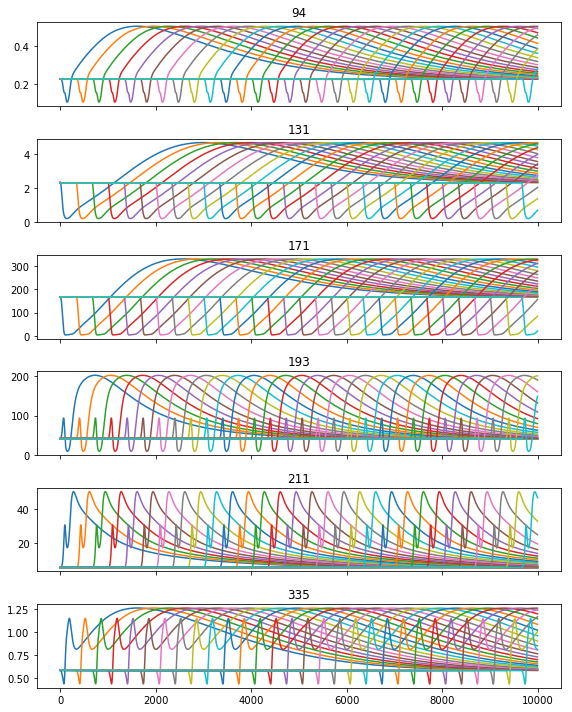

In [225]:
fig,ax = plt.subplots(len(aia.channels),1,figsize=(8,10),sharex=True)
for i,chan in enumerate(aia.channels):
    for ts in timeseries:
        ax[i].plot(ts['time'],ts['intensity'][chan['name']])
    ax[i].set_title(f'{chan["name"]}')
plt.tight_layout()

(0.01, 1000000.0)

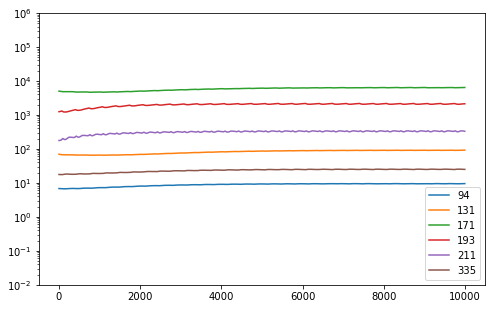

In [226]:
plt.figure(figsize=(8,5))
for chan in aia.channels:
    plt.plot(timeseries[0]['time'],np.array([ts['intensity'][chan['name']] for ts in timeseries]).sum(axis=0),
             label=chan['name'])
plt.legend()
plt.yscale('log')
plt.ylim(1e-2,1e6)

What if all of the events occurred on the same fieldline?

In [227]:
num_events = 30
interval = base['total_time']/num_events
duration = 200.0
event_list = []
for i in range(num_events):
    config = base.copy()
    rise_start = i*interval
    event_list.append({'event':{'decay_start': rise_start+duration/2., 'decay_end':rise_start+duration,
                                             'rise_start': rise_start, 'rise_end': rise_start+duration/2.,
                                             'magnitude':np.random.uniform(low=1e-3,high=1e-3)}})
config['heating']['events'] = event_list
oh = xml_io.OutputHandler(base['output_filename']+'.xml',config)
oh.print_to_xml()
subprocess.call(['/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/bin/ebtel++.run', '-c',
                 base['output_filename']+'.xml'])
res = np.loadtxt(base['output_filename'])
t,Te,n = res[:,0],res[:,1],res[:,3]
intensity = {}
for chan in aia.channels:
    response = splev(Te,chan['temperature_response_spline'])
    intensity[chan['name']] = (n**2)*response*config['loop_length']
timeseries_single_loop = {'time':t,'intensity':intensity}

(0.01, 1000000.0)

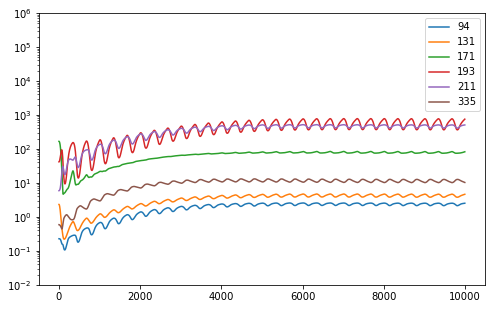

In [228]:
plt.figure(figsize=(8,5))
for chan in aia.channels:
    plt.plot(timeseries_single_loop['time'],
             timeseries_single_loop['intensity'][chan['name']],
             label=chan['name'])
plt.legend()
plt.yscale('log')
plt.ylim(1e-2,1e6)

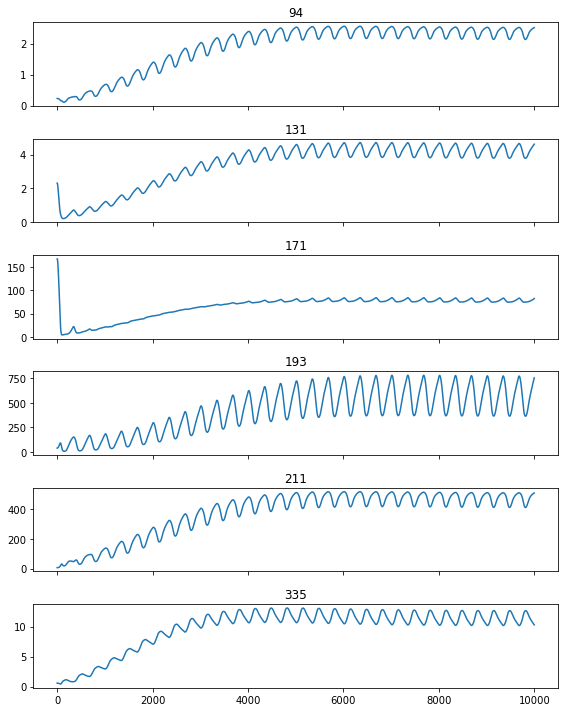

In [229]:
fig,ax = plt.subplots(len(aia.channels),1,figsize=(8,10),sharex=True)
for i,chan in enumerate(aia.channels):
    ax[i].plot(timeseries_single_loop['time'],
             timeseries_single_loop['intensity'][chan['name']])
    ax[i].set_title(f'{chan["name"]}')
plt.tight_layout()

Compare the two cases 

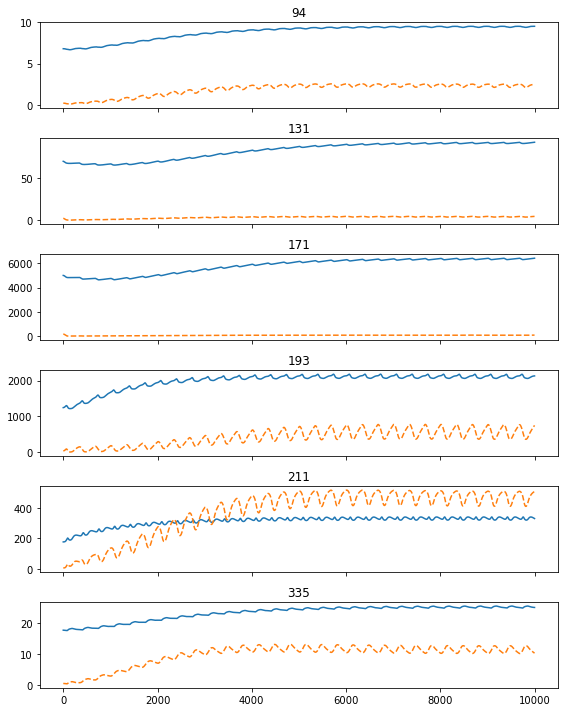

In [230]:
fig,ax = plt.subplots(len(aia.channels),1,figsize=(8,10),sharex=True)
for i,chan in enumerate(aia.channels):
    # Multiple loops, one event per loop
    ax[i].plot(timeseries[0]['time'],
               np.array([ts['intensity'][chan['name']] for ts in timeseries]).sum(axis=0),
               ls='-',color='C0')
    # Single loop, multiple events
    ax[i].plot(timeseries_single_loop['time'],
             timeseries_single_loop['intensity'][chan['name']],
              ls='--',color='C1')
    ax[i].set_title(f'{chan["name"]}')
plt.tight_layout()

## Fourier Analysis

In [151]:
time_foo = timeseries_single_loop['time']
intensity_foo = timeseries_single_loop['intensity']['94']

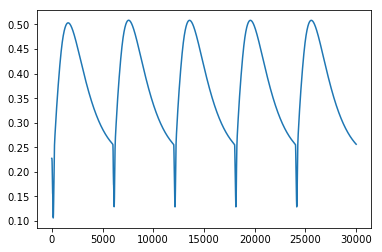

In [152]:
plt.plot(time_foo,intensity_foo)

In [153]:
freq = np.fft.fftshift(np.fft.fftfreq(intensity_foo.size,d=np.diff(time_foo)[0]))
spec = np.fft.fftshift(np.abs(np.fft.fft(intensity_foo)))

(-0.01, 0.01)

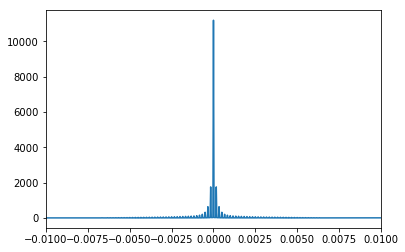

In [157]:
plt.plot(freq,spec)
plt.xlim(-.01,.01)